# Import All Neccesary Packages

In [1]:
#Install/Upgrade dependencies
!pip install --upgrade awscli --user
!pip install --upgrade pip
!pip install --upgrade boto3
!pip install --upgrade botocore
!pip install --upgrade scikit-learn
!pip install --upgrade sagemaker
!pip install --upgrade nltk
!pip install --upgrade seaborn
!pip install sagemaker boto3 scikit-learn scipy matplotlib wordcloud seaborn pandas

In [2]:
import boto3
import os, io, struct
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import sagemaker
from sagemaker import get_execution_role
import boto3
from sklearn.feature_extraction.text import CountVectorizer
import re
import os
from scipy.sparse import csr_matrix
from sagemaker.amazon.common import write_spmatrix_to_sparse_tensor
from sagemaker.inputs import TrainingInput
from sagemaker import LDA
from sagemaker.amazon.common import RecordSerializer
from sagemaker.deserializers import JSONDeserializer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:172: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[11/21/24 01:07:52] INFO     Found credentials from IAM Role:                                   ]8;id=38689;file:///home/ec2-user/.local/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=703883;file:///home/ec2-user/.local/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Define Some Helper Functions

In [3]:
from nltk.stem import SnowballStemmer

def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()
    
def print_metrics(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print( f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 
    
from sklearn.model_selection import train_test_split
# uncomment the following lines and implement your solution
def split_data(df):
    # train, test_and_validate = train_test_split(....)
    # test, validate = train_test_split(....)
    ### BEGIN_SOLUTION
    train, test_and_validate = train_test_split(df,
                                            test_size=0.2,
                                            shuffle=True,
                                            random_state=324
                                            )
    test, validate = train_test_split(test_and_validate,
                                                test_size=0.5,
                                                shuffle=True,
                                                random_state=324)
    ### END_SOLUTION
    return train, validate, test


snow = SnowballStemmer('english')
def clean(sent):
    # Implement this function
    sent = sent.lower()
    sent = re.sub('\s+', ' ', sent)
    ### BEGIN_SOLUTION
    sent = sent.strip()
    sent = re.compile('<.*?>').sub('',sent)
    ### END_SOLUTION
    filtered_sentence = []
    
    for w in word_tokenize(sent):
        # You are applying custom filtering here. Feel free to try different things.
        # Check if it is not numeric, its length > 2, and it is not in stopwords
        if(not w.isnumeric()) and (len(w)>2) and (w not in stopwords):  
            # Stem and add to filtered list
            filtered_sentence.append(snow.stem(w))
    final_string = " ".join(filtered_sentence) #final string of cleaned words
    return final_string

def remove_stopwords(stopwords):
    # Implement this function
    excluding = ['against', 'not', 'don', 'don\'t','ain', 'are', 'aren\'t']
    ### BEGIN_SOLUTION
    excluding = ['against', 'not', 'don', 'don\'t','ain', 'are', 'aren\'t', 'could', 'couldn\'t',
             'did', 'didn\'t', 'does', 'doesn\'t', 'had', 'hadn\'t', 'has', 'hasn\'t', 
             'have', 'haven\'t', 'is', 'isn\'t', 'might', 'mightn\'t', 'must', 'mustn\'t',
             'need', 'needn\'t','should', 'shouldn\'t', 'was', 'wasn\'t', 'were', 
             'weren\'t', 'won\'t', 'would', 'wouldn\'t']
    ### END_SOLUTION
    return [word for word in stop if word not in excluding]




# Data Exploration 

In [4]:
df=pd.read_csv("qatar_airways_reviews.csv")
df.head()

,Unnamed: 0,Date Published,Rating,Max Rating,Title,Author,Country,Date,Review Body,Type Of Traveller,Seat Type,Route,Date Flown,Recommended,Aircraft,Verified
0,0,2024-03-02,1.0,10.0,“marred by inconveniences”,Mary Le,United Kingdom,2024-03-02,The delay of my flight from Haneda to Doha ca...,Solo Leisure,Economy Class,Tokyo to London Heathrow via Doha,March 2024,no,NaN,0.0
1,1,2024-02-29,1.0,10.0,"""seat wouldn't stay up""",Brian English,Canada,2024-02-29,They convinced me that I needed to pay $1500...,Couple Leisure,Business Class,Doha to Montreal,February 2024,no,NaN,1.0
2,2,2024-02-29,1.0,10.0,"""no attempt to address our complaint""",Wayne Burgess,Australia,2024-02-29,I have sent 5 emails and have only received ...,Business,Economy Class,Doha to Perth,November 2023,no,A380,1.0
3,3,2024-02-25,10.0,10.0,“I hope they update the A380”,Alwaleed Althani,Qatar,2024-02-25,We flew on probably the first A380 the airlin...,Couple Leisure,First Class,Doha to London Heathrow,February 2024,NaN,A380-800,1.0
4,4,2024-02-22,7.0,10.0,"""I’d rate them maybe 7/10""",W Warnock,United Kingdom,2024-02-22,"Service was ok, pretty good on my aisle and ...",Couple Leisure,Business Class,Auckland to Doha,February 2024,no,A350,1.0


In [5]:
df.isna().sum()

Unnamed: 0              0
Date Published          0
Rating                  1
Max Rating              1
Title                   0
Author                  0
Country                 0
Date                    0
Review Body             0
Type Of Traveller     435
Seat Type               0
Route                 438
Date Flown            444
Recommended          1781
Aircraft             1088
Verified             1117
dtype: int64

In [6]:
#Drop columns with Many NANS
df=df.dropna(axis=1,thresh=len(df)-100)
df

,Unnamed: 0,Date Published,Rating,Max Rating,Title,Author,Country,Date,Review Body,Seat Type
0,0,2024-03-02,1.0,10.0,“marred by inconveniences”,Mary Le,United Kingdom,2024-03-02,The delay of my flight from Haneda to Doha ca...,Economy Class
1,1,2024-02-29,1.0,10.0,"""seat wouldn't stay up""",Brian English,Canada,2024-02-29,They convinced me that I needed to pay $1500...,Business Class
2,2,2024-02-29,1.0,10.0,"""no attempt to address our complaint""",Wayne Burgess,Australia,2024-02-29,I have sent 5 emails and have only received ...,Economy Class
3,3,2024-02-25,10.0,10.0,“I hope they update the A380”,Alwaleed Althani,Qatar,2024-02-25,We flew on probably the first A380 the airlin...,First Class
4,4,2024-02-22,7.0,10.0,"""I’d rate them maybe 7/10""",W Warnock,United Kingdom,2024-02-22,"Service was ok, pretty good on my aisle and ...",Business Class
...,...,...,...,...,...,...,...,...,...,...
2364,2364,2013-08-12,9.0,10.0,Qatar Airways customer review,R Nash,Australia,2013-08-12,Flew first class CAI-DOH on QR503 on 8th Aug 2...,First Class
2365,2365,2013-08-06,7.0,10.0,Qatar Airways customer review,Gamage Champika,United Arab Emirates,2013-08-06,I took a flight to London on 17th July with my...,Economy Class
2366,2366,2013-08-06,5.0,10.0,Qatar Airways customer review,Martin Fernandez,Spain,2013-08-06,MAD-DOH-DXB and back. Boeing 777 in MAD-DOH se...,Economy Class
2367,2367,2013-08-06,7.0,10.0,Qatar Airways customer review,David Monteiro,Switzerland,2013-08-06,GVA-AUH A320. Good food but after the main mea...,Economy Class


In [7]:
#Drop nans in the rating columns 
df=df.dropna(axis=0)
df

,Unnamed: 0,Date Published,Rating,Max Rating,Title,Author,Country,Date,Review Body,Seat Type
0,0,2024-03-02,1.0,10.0,“marred by inconveniences”,Mary Le,United Kingdom,2024-03-02,The delay of my flight from Haneda to Doha ca...,Economy Class
1,1,2024-02-29,1.0,10.0,"""seat wouldn't stay up""",Brian English,Canada,2024-02-29,They convinced me that I needed to pay $1500...,Business Class
2,2,2024-02-29,1.0,10.0,"""no attempt to address our complaint""",Wayne Burgess,Australia,2024-02-29,I have sent 5 emails and have only received ...,Economy Class
3,3,2024-02-25,10.0,10.0,“I hope they update the A380”,Alwaleed Althani,Qatar,2024-02-25,We flew on probably the first A380 the airlin...,First Class
4,4,2024-02-22,7.0,10.0,"""I’d rate them maybe 7/10""",W Warnock,United Kingdom,2024-02-22,"Service was ok, pretty good on my aisle and ...",Business Class
...,...,...,...,...,...,...,...,...,...,...
2364,2364,2013-08-12,9.0,10.0,Qatar Airways customer review,R Nash,Australia,2013-08-12,Flew first class CAI-DOH on QR503 on 8th Aug 2...,First Class
2365,2365,2013-08-06,7.0,10.0,Qatar Airways customer review,Gamage Champika,United Arab Emirates,2013-08-06,I took a flight to London on 17th July with my...,Economy Class
2366,2366,2013-08-06,5.0,10.0,Qatar Airways customer review,Martin Fernandez,Spain,2013-08-06,MAD-DOH-DXB and back. Boeing 777 in MAD-DOH se...,Economy Class
2367,2367,2013-08-06,7.0,10.0,Qatar Airways customer review,David Monteiro,Switzerland,2013-08-06,GVA-AUH A320. Good food but after the main mea...,Economy Class


In [8]:
df.isna().sum()

Unnamed: 0        0
Date Published    0
Rating            0
Max Rating        0
Title             0
Author            0
Country           0
Date              0
Review Body       0
Seat Type         0
dtype: int64

In [9]:
#Drop Irrelvant columns 
df=df.drop(['Date Published','Title','Author','Country','Date','Seat Type'],axis=1)
df

,Unnamed: 0,Rating,Max Rating,Review Body
0,0,1.0,10.0,The delay of my flight from Haneda to Doha ca...
1,1,1.0,10.0,They convinced me that I needed to pay $1500...
2,2,1.0,10.0,I have sent 5 emails and have only received ...
3,3,10.0,10.0,We flew on probably the first A380 the airlin...
4,4,7.0,10.0,"Service was ok, pretty good on my aisle and ..."
...,...,...,...,...
2364,2364,9.0,10.0,Flew first class CAI-DOH on QR503 on 8th Aug 2...
2365,2365,7.0,10.0,I took a flight to London on 17th July with my...
2366,2366,5.0,10.0,MAD-DOH-DXB and back. Boeing 777 in MAD-DOH se...
2367,2367,7.0,10.0,GVA-AUH A320. Good food but after the main mea...


In [10]:
def sentiment(rating, max_rating): 
    if (rating / max_rating > 0.5):
        return 0
    elif (rating / max_rating <= 0.5):
        return 1
    else:
        return 'ERROR'


In [11]:
df['Sentiment']= df.apply (lambda x: sentiment(x['Rating'],x['Max Rating']),axis=1)
df

,Unnamed: 0,Rating,Max Rating,Review Body,Sentiment
0,0,1.0,10.0,The delay of my flight from Haneda to Doha ca...,1
1,1,1.0,10.0,They convinced me that I needed to pay $1500...,1
2,2,1.0,10.0,I have sent 5 emails and have only received ...,1
3,3,10.0,10.0,We flew on probably the first A380 the airlin...,0
4,4,7.0,10.0,"Service was ok, pretty good on my aisle and ...",0
...,...,...,...,...,...
2364,2364,9.0,10.0,Flew first class CAI-DOH on QR503 on 8th Aug 2...,0
2365,2365,7.0,10.0,I took a flight to London on 17th July with my...,0
2366,2366,5.0,10.0,MAD-DOH-DXB and back. Boeing 777 in MAD-DOH se...,1
2367,2367,7.0,10.0,GVA-AUH A320. Good food but after the main mea...,0


In [12]:
df=df.drop(['Rating','Max Rating'],axis=1)

<Axes: >

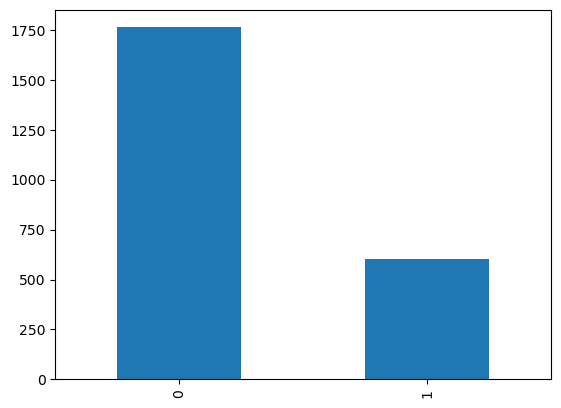

In [13]:
df['Sentiment'].value_counts().plot(kind='bar')

In [14]:
df = df.drop(columns=['Unnamed: 0'])
df

,Review Body,Sentiment
0,The delay of my flight from Haneda to Doha ca...,1
1,They convinced me that I needed to pay $1500...,1
2,I have sent 5 emails and have only received ...,1
3,We flew on probably the first A380 the airlin...,0
4,"Service was ok, pretty good on my aisle and ...",0
...,...,...
2364,Flew first class CAI-DOH on QR503 on 8th Aug 2...,0
2365,I took a flight to London on 17th July with my...,0
2366,MAD-DOH-DXB and back. Boeing 777 in MAD-DOH se...,1
2367,GVA-AUH A320. Good food but after the main mea...,0


# Prepare the Data for the Model

In [15]:
#Split the data 
train, validate, test = split_data(df)
